## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve,  confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 as resnet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, Reshape
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.utils import multi_gpu_model
import multiprocessing as mp
cpu_count = mp.cpu_count()

print(tf.__version__)

2.2.0


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
all_xray_df = pd.read_csv('Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
49281,00012500_001.png,No Finding,1,12500,14,F,PA,2500,2048,0.168,0.168,NaN,None
78079,00019172_000.png,No Finding,0,19172,55,F,PA,2678,2989,0.143,0.143,NaN,None
24749,00006500_009.png,Effusion,9,6500,56,M,AP,2500,2048,0.168,0.168,NaN,None


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
finding_labels = list(all_xray_df['Finding Labels'].unique())
diseases = set()
for labels in finding_labels:
    for x in labels.split('|'):
        diseases.add(x)
diseases

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = 0
all_xray_df['pneumonia_class'][all_xray_df['Finding Labels'].str.contains('Pneumonia')] = 1


/home/soon/venv/imgentf2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Create your training and testing data:

In [5]:
def create_splits(df, test_size, column_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(df, test_size=test_size,
                                           stratify = df[column_name])
    
    train_data = train_data.groupby('pneumonia_class').apply(lambda x: x.sample(n=len(train_data)//2, replace=True))
    
    return train_data, val_data

train_df, val_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')

## Class Balancing
The train dataset contains 50% positive and 50% negative samples. It is obtained by sampling with replace from 80% of dataset. The remaining 20% dataset is used as validation set, and the ratio of 98.7% negative against 1.27% positive is the same as the ratio for entire sample.

In [6]:
train_df.pneumonia_class.value_counts(normalize=True)

1    0.5
0    0.5
Name: pneumonia_class, dtype: float64

In [7]:
val_df.pneumonia_class.value_counts(normalize=True)

0    0.987246
1    0.012754
Name: pneumonia_class, dtype: float64

# Age and Gender distribution of train and validation dataset

Statistics of patient age in training set


count    89696.000000
mean        45.713231
std         17.372651
min          1.000000
25%         33.000000
50%         48.000000
75%         59.000000
max        414.000000
Name: Patient Age, dtype: float64

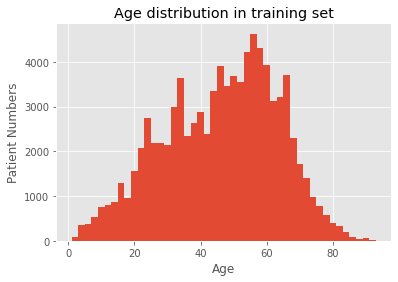

In [62]:
train_df['Patient Age'].hist(bins=np.arange(1,95,2))
plt.xlabel('Age')
plt.ylabel('Patient Numbers')
plt.title('Age distribution in training set')
print("Statistics of patient age in training set")
train_df['Patient Age'].describe()

Statistics of patient age in validation set


count    22424.000000
mean        46.932706
std         17.052450
min          1.000000
25%         34.000000
50%         49.000000
75%         59.000000
max        412.000000
Name: Patient Age, dtype: float64

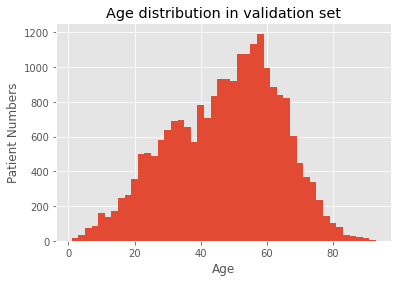

In [63]:
val_df['Patient Age'].hist(bins=np.arange(1,95,2))
plt.xlabel('Age')
plt.ylabel('Patient Numbers')
plt.title('Age distribution in validation set')
print("Statistics of patient age in validation set")
val_df['Patient Age'].describe()

In [66]:
print("Gender distribution of training set")
train_df['Patient Gender'].value_counts(normalize=True)

Gender distribution of training set


M    0.570505
F    0.429495
Name: Patient Gender, dtype: float64

In [67]:
print("Gender distribution of validation set")
val_df['Patient Gender'].value_counts(normalize=True)

Gender distribution of validation set


M    0.56337
F    0.43663
Name: Patient Gender, dtype: float64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [26]:
def my_image_augmentation():
    
    idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.15, 
                                  width_shift_range=0.15, 
                                  rotation_range=25, 
                                  shear_range = 0.1,
                                  zoom_range=0.1)

    return idg


def make_train_gen(df, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df, 
                                          directory="images", 
                                          x_col = "Image Index",
                                          y_col = "pneumonia_class",
                                          class_mode = 'raw',
                                          target_size = (224, 224), 
                                          batch_size = batch_size
                                          )

    return train_gen


def make_val_gen(df, batch_size):
    my_val_idg = ImageDataGenerator(rescale=1./255.)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df, 
                                             shuffle = False,
                                             directory="images", 
                                             x_col = 'Image Index',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'raw',
                                             target_size = (224, 224), 
                                             batch_size = batch_size) 
    

    return val_gen

batch_size = 64
train_gen = make_train_gen(train_df, batch_size)
val_gen = make_val_gen(val_df, batch_size)

Found 89696 validated image filenames.
Found 22424 validated image filenames.


In [27]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()


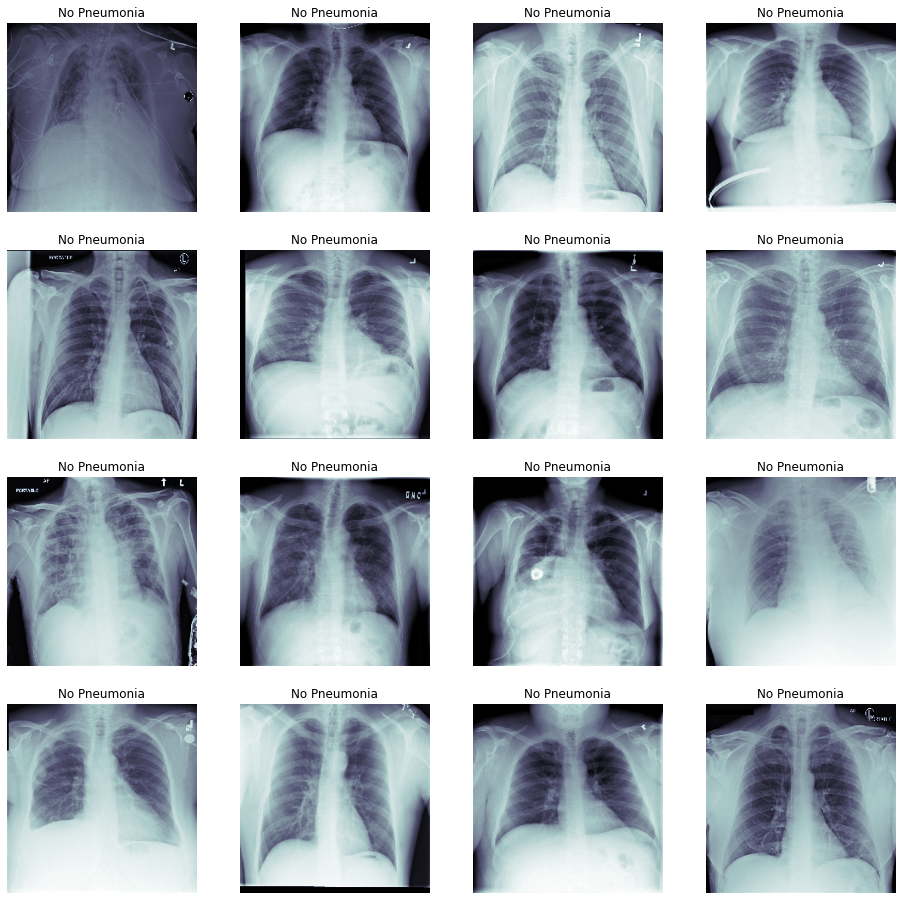

In [28]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [29]:
def load_pretrained_model():
    
    backbone = resnet(include_top=False, weights='imagenet')
    #for layer in backbone.layers:
    #    layer.trainable = False
    
    model = Model(inputs=backbone.input,
                  outputs=backbone.output, name='Resnet')
 
    #model.summary()
    return model

In [30]:
def build_my_model():
    
    backbone = load_pretrained_model()

    model = Sequential([backbone,
                        BatchNormalization(),
                        Conv2D(1024, 1, activation='relu'),
                        Dropout(0.5),
                        BatchNormalization(),
                        Conv2D(256, 1, activation='relu'),
                        Dropout(0.5),                        
                        AveragePooling2D((7,7)),
                        BatchNormalization(),
                        Conv2D(1, 1, activation='sigmoid'),
                        Reshape((-1,))
                       ])
    
    return model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [68]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop

weight_path="./weights/{}_my_model_1.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_binary_accuracy", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_binary_accuracy", 
                      mode= "auto", 
                      patience = 5)

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, early, lr_scheduler]

### Start training! 

In [13]:
    my_model = build_my_model()

In [32]:
## train your model
#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():
    
    my_model = build_my_model()

    if os.path.exists(weight_path):
        my_model.load_weights(weight_path)

    my_model.compile(
        optimizer=RMSprop(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()])

    history = my_model.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = 25, 
                              workers = cpu_count-1,
                              use_multiprocessing = False,
                              callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
1402/1402 [==============================] - ETA: 0s - loss: 0.2719 - binary_accuracy: 0.8876
Epoch 00001: val_binary_accuracy improved from -inf to 0.93750, saving model to ./weights/xray_class_my_model_1.best.hdf5
1402/1402 [==============================] - 417s 297ms/step - loss: 0.2719 - binary_accuracy: 0.8876 - val_loss: 0.2665 - val_binary_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 2/25
1402/1402 [==============================] - ETA: 0s - loss: 0.1227 - binary_accuracy: 0.9543
Epoch 00002: val_binary_accuracy did not improve from 0.93750
1402/1402 [==============================] - 418s 298ms/step - loss: 0.1227 - binary_accuracy: 0.9543 - val_loss: 0.2550 - val_binary_accuracy: 0.9062 - lr: 9.0484e-05
Epoch 3/25
1402/1402 [==============================] - ETA: 0s - loss: 0.0817 - binary_accuracy: 0.9709
Epoch 00003: val_binary_accuracy improved from 0.93750 to 0.96875, saving model to ./weig

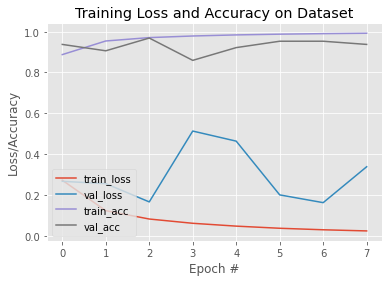

In [33]:
def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

plot_history(history)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [34]:
my_model.load_weights(weight_path)
accum_label = []
accum_pred = []
#val_Y = val_df['pneumonia_class']

for _ in range(100):
    valX, valY = val_gen.next()
    predY = my_model.predict(valX, workers=cpu_count-1)
    predY = predY.reshape(-1)
    accum_label = np.concatenate((accum_label, valY))
    accum_pred = np.concatenate((accum_pred, predY))

In [44]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    
def plot_f1(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    f1_scores = []
    thresholds = []
    max_f1 = 0
    best_threshold = None
    for t in np.arange(0.0,1,0.01):        
        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)
        if max_f1 < f1:
            max_f1 = f1
            best_threshold = t
        f1_scores.append(f1)
        thresholds.append(t)
    
    c_ax.plot(thresholds, f1_scores,
              label = '%s (Best F1 Score:%0.2f with threshold %.2f)'  % ('Pneumonia', max_f1, best_threshold))
    c_ax.legend()
    c_ax.set_xlabel('threshold')
    c_ax.set_ylabel('f1')
    
#Also consider plotting the history of your model training:



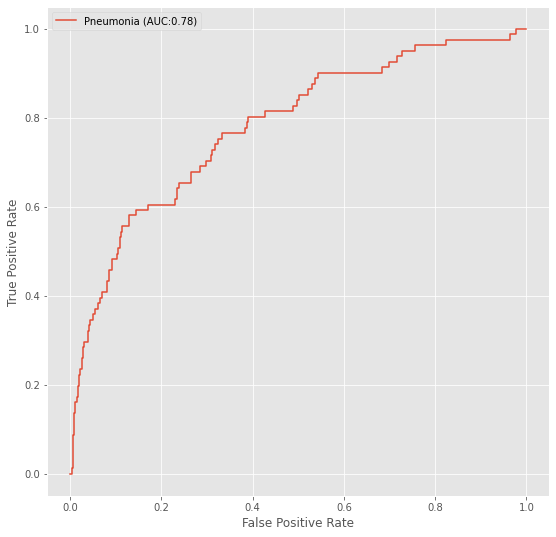

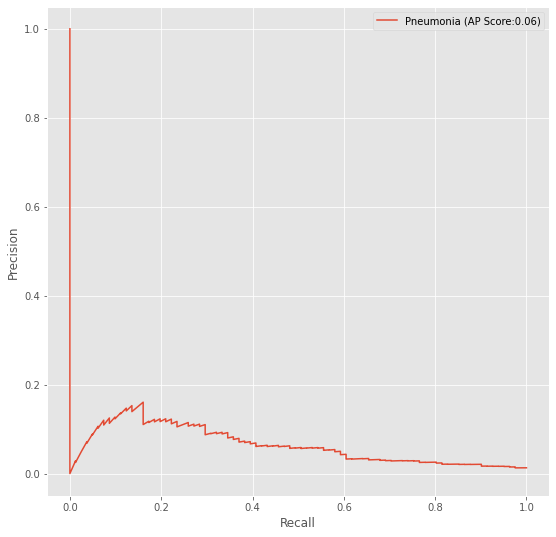

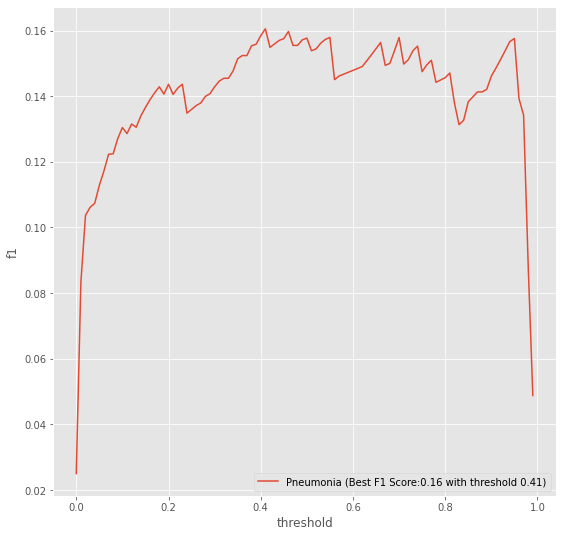

In [45]:
## plot figures
plot_auc(accum_label, accum_pred)
plot_pr(accum_label, accum_pred)
plot_f1(accum_label, accum_pred)
#print("precision: %.2f recall: %.2f thresholds:%.2f"%(precision, recall, thresholds))

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

## The best F1 score and its threshold is calculated when plotting the F1 against threshold chart in above. 

In [47]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(accum_label, accum_pred)

# Look at the threshold where precision is 0.8
#precision_value = 0.3
#idx = (np.abs(precision - precision_value)).argmin() 
threshold = 0.41
#recall_value = 0.20
idx = (np.abs(thresholds - threshold)).argmin() 


precision_1 = precision[idx]
recall_1 = recall[idx]
threshold_1 = thresholds[idx]
f1_1 = calc_f1(precision[idx],recall[idx])
               
print('Precision is: %.4f'%precision_1)
print('Recall is: %.4f'%recall_1)
print('Threshold is: %.4f'%threshold_1)
print('F1 Score is: %.4f'%f1_1)


YOUR_THRESHOLD = threshold_1
print(YOUR_THRESHOLD)

Precision is: 0.1096
Recall is: 0.2963
Threshold is: 0.4086
F1 Score is: 0.1600
0.40863803029060364


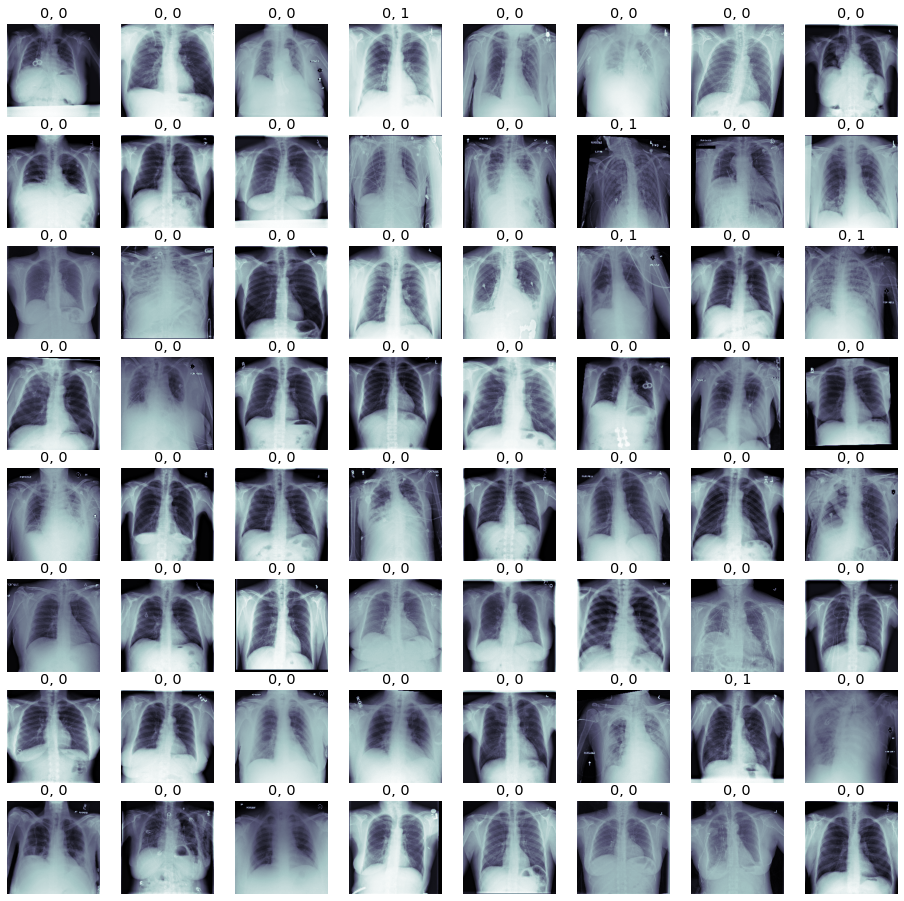

In [51]:
## Let's look at some examples of predicted v. true with our best model: 
valX, valY = val_gen.next()
predY = my_model.predict(valX, workers=cpu_count-1)
predY = predY.reshape(-1)
fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if predY[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if predY[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [69]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)